In [66]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

# Phase 0 : exploring the data

In [2]:
df=pd.read_csv("spam.csv",encoding = "ISO-8859-1")

In [3]:
# We drop the redundent looking columns
unuseful = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
df = df.drop(df[unuseful], axis=1)

# We rename the columns in order to make them more understandable
df.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Phase 1: Data Preprocessing

In order to further process the data, we need to make the data cleaner.

In the first step we extract only the alphabetic characters, so we remove punctuation and numbers. Then we convert all the characters into lowercase.

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dcacc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# pre-process a text : clean, tokenize and stem each word in text
def pre_processing(text):
    lemmatizer=WordNetLemmatizer()
    # removing punctuation, lowercase the text, removing stopwords, map punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    p_text = text.translate(translator).lower()
    ppt = ""
    for word in p_text.split():
        if word not in stopwords.words('english'):
            ppt += word + " "
    text = ppt.strip(" ")
    token_words = word_tokenize(text)
    lem_sentence = []
    for word in token_words:
        lem_sentence.append(lemmatizer.lemmatize(word, pos ='v'))
    return ' '.join(lem_sentence)

df["Pre_processed_text"] = df["Text"].apply(pre_processing)

In [6]:
#it creates a list of all the words
bag_words = set()
for sms in df["Pre_processed_text"]:
    #print(sms)
    for w in sms.split(" "):
        if w != "":
            bag_words = bag_words.union({w})
bag = list(bag_words)

# Phase 2: extracting the features

In [7]:
#it returns a list of words for each sms
def split_words(text, bag_words):
    return text.split(" ")

In [8]:
df["Words"] = df["Pre_processed_text"].apply(split_words, args = (bag_words,))

In [9]:
bag_len = len(bag)
def vectorize_sms(words):
    vector = np.zeros(bag_len,dtype="int64")
    for i in range(bag_len):
        if bag[i] in words:
            vector[i] += 1
    return vector
df["Vector"] = df["Words"].apply(vectorize_sms)
df 

,Target,Text,Pre_processed_text,Words,Vector
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live around though,"[nah, think, go, usf, live, around, though]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u å£750 pound prize 2...,"[2nd, time, try, 2, contact, u, u, å£750, poun...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5568,ham,Will Ì_ b going to esplanade fr home?,ì b go esplanade fr home,"[ì, b, go, esplanade, fr, home]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood suggestions,"[pity, mood, suggestions]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5570,ham,The guy did some bitching but I acted like i'd...,guy bitch act like interest buy something else...,"[guy, bitch, act, like, interest, buy, somethi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
X=np.zeros((len(df),bag_len),dtype="int64")
for i in range(len(df)):
    X[i]+=df.iloc[i,4]
pd.DataFrame(X,columns=bag)

,problem,nobbing,castor,checkin,wherre,bevies,station,spanish,doesdiscount,steyn,...,tech,rpl,argentina,ela,cornwall,hm,flippin,89938,redeemable,ibhltd
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y=np.zeros(len(df),dtype="int64")
for i in range(len(df["Target"])):
    if df.iloc[i,0]=="ham":
        y[i]=0
    else:
        y[i]=1

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((4457, 7644), (4457,))

In [13]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
N_yi = np.zeros((2, bag_len)) # feature count
N_y = np.zeros((2)) # total count 
for i in range(len(y_train)):
    # Compute N_y counting the features for each specific class
    N_y[y_train[i]] += np.sum(X_train[i])
    # Compute N_yi adding counting the specific words in each class
    N_yi[y_train[i]] += (X_train[i])
print(N_yi)

[[28.  1.  2. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  2.]]


# Prior 

In [15]:
P = np.zeros(2)
classes=np.unique(y_train)
# Implement Prior Probability P(A)
for j in classes:
    P[j] = np.count_nonzero(y_train == j)/(len(y_train))
print(P)

[0.8660534 0.1339466]


# Likelihood

In [16]:
import math

In [17]:
likelihood_matrix_words=np.zeros((2,bag_len))
for i in range(bag_len):
    for j in range(2):
        likelihood_matrix_words[j][i]=float((N_yi[j][i] + 1)/(N_y[j] + bag_len))
likelihood_matrix_words=pd.DataFrame(likelihood_matrix_words,columns=bag)

In [18]:
likelihood_matrix_words

,problem,nobbing,castor,checkin,wherre,bevies,station,spanish,doesdiscount,steyn,...,tech,rpl,argentina,ela,cornwall,hm,flippin,89938,redeemable,ibhltd
0,0.000776,0.000054,0.000080,0.000054,0.000054,0.000054,0.000187,0.000054,0.000054,0.000027,...,0.000054,0.000027,0.000027,0.000054,0.000054,0.000080,0.000027,0.000027,0.000027,0.000027
1,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.000111,0.000167,0.000056,0.000056,...,0.000056,0.000111,0.000056,0.000056,0.000167,0.000056,0.000056,0.000111,0.000056,0.000167


In [19]:
likelihood_matrix=np.zeros((len(X_train),2))
for i in range(len(X_train)):
    tmp_spam=[]
    tmp_ham=[]
    sms=X_train[i] #list of words
    for index in range(len(sms)): #for each word in sms
        if sms[index]!=0:
            weight_ham,weight_spam=likelihood_matrix_words.iloc[:,index]
            tmp_spam.append(math.log(weight_spam)**sms[index])
            tmp_ham.append(math.log(weight_ham)**sms[index])
    likelihood_matrix[i][0]=float(np.sum(tmp_ham))
    likelihood_matrix[i][1]=float(np.sum(tmp_spam))

In [20]:
likelihood_matrix=pd.DataFrame(likelihood_matrix,columns=["ham","spam"])

In [21]:
likelihood_matrix

,ham,spam
0,-54.434155,-62.207409
1,-137.468846,-123.164313
2,-47.935712,-50.348928
3,-46.803153,-56.129671
4,-180.748513,-142.225845
...,...,...
4452,-53.888084,-66.716916
4453,-16.839779,-22.429726
4454,-50.434432,-57.382434
4455,-29.822265,-35.846948


In [22]:
likelihood_matrix["ham"] = likelihood_matrix["ham"]+math.log(P[0])

In [23]:
likelihood_matrix["spam"] = likelihood_matrix["spam"]+math.log(P[1])

In [24]:
likelihood_matrix.iloc[0:10,:]

,ham,spam
0,-54.577964,-64.217723
1,-137.612654,-125.174627
2,-48.079520,-52.359242
3,-46.946962,-58.139986
4,-180.892322,-144.236159
5,-53.850110,-62.859600
6,-35.791139,-35.178199
7,-49.437304,-59.392749
8,-11.986493,-18.267686
9,-47.172168,-54.710617


In [40]:
likelihood_matrix['prob_spam'] = abs(likelihood_matrix['spam']) / (abs(likelihood_matrix['spam']) + abs(likelihood_matrix['ham']))

In [41]:
likelihood_matrix.iloc[0:10,:]

,ham,spam,prob_spam
0,-54.577964,-64.217723,0.540573
1,-137.612654,-125.174627,0.476334
2,-48.079520,-52.359242,0.521305
3,-46.946962,-58.139986,0.553256
4,-180.892322,-144.236159,0.443628
5,-53.850110,-62.859600,0.538598
6,-35.791139,-35.178199,0.495682
7,-49.437304,-59.392749,0.545738
8,-11.986493,-18.267686,0.603807
9,-47.172168,-54.710617,0.536996


In [25]:
res=likelihood_matrix.idxmax(axis=1)
res=res.replace("ham",0)
res=res.replace("spam",1)
print(res)

0       0
1       1
2       0
3       0
4       1
       ..
4452    0
4453    0
4454    0
4455    0
4456    0
Length: 4457, dtype: int64


In [26]:
bools=(res==y_train)

In [27]:
bools.value_counts()

True     4432
False      25
dtype: int64

In [29]:
confusion_matrix(y_train, res)

array([[3852,    8],
       [  17,  580]], dtype=int64)

In [69]:
fpr, tpr, threshold = roc_curve(y_train, 1 - likelihood_matrix['prob_spam'])

In [71]:
auc(fpr, tpr)

0.9986972860850019

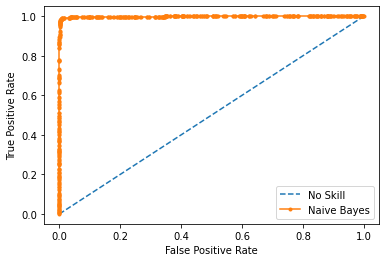

In [70]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Bag of words va fatta solo su X train

In [78]:
likelihood_matrix=np.zeros((len(X_test),2))
for i in range(len(X_test)):
    tmp_spam=[]
    tmp_ham=[]
    sms=X_test[i] #list of words
    for index in range(len(sms)): #for each word in sms
        if sms[index]!=0:           
                weight_ham,weight_spam=likelihood_matrix_words.iloc[:,index]
                tmp_spam.append(math.log(weight_spam)**sms[index])
                tmp_ham.append(math.log(weight_ham)**sms[index])
    likelihood_matrix[i][0]=float(np.sum(tmp_ham))
    likelihood_matrix[i][1]=float(np.sum(tmp_spam))

In [79]:
likelihood_matrix=pd.DataFrame(likelihood_matrix,columns=["ham","spam"])

In [80]:
likelihood_matrix["ham"] = likelihood_matrix["ham"]+math.log(P[0])
likelihood_matrix["spam"] = likelihood_matrix["spam"]+math.log(P[1])

In [75]:
#likelihood_matrix['prob_spam'] = abs(likelihood_matrix['spam']) / (abs(likelihood_matrix['spam']) + abs(likelihood_matrix['ham']))

In [81]:
likelihood_matrix.iloc[0:10,:]

,ham,spam
0,-170.514090,-175.519219
1,-151.965611,-156.268451
2,-82.402432,-73.924771
3,-55.338686,-70.475702
4,-193.566763,-142.435834
5,-34.750340,-41.972365
6,-11.818712,-17.793228
7,-25.040481,-28.098842
8,-97.578345,-117.886586
9,-24.685176,-29.602919


In [83]:
res=likelihood_matrix.idxmax(axis=1)
res=res.replace("ham",0)
res=res.replace("spam",1)
print(res)

0       0
1       0
2       1
3       0
4       1
       ..
1110    0
1111    0
1112    0
1113    0
1114    1
Length: 1115, dtype: int64


In [85]:
confusion_matrix(y_test, res)

array([[955,  10],
       [ 12, 138]], dtype=int64)

In [87]:
fpr, tpr, threshold = roc_curve(y_test, res)

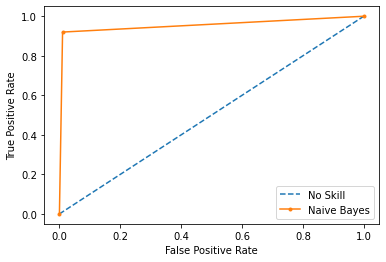

In [88]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()